In [135]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# from tools import *

In [136]:
# -*- coding: utf-8 -*-

def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),256)

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y


def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex//2))
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex//2))
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex//4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex//4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(int(nbex//2))))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y


# 1. Données et classifieur bayésien naïf

## Etude du jeu de données artificielles

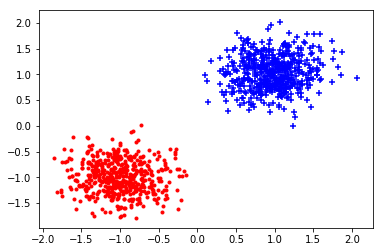

In [137]:
# Visualisation des données
data0, y0 = gen_arti(data_type=0)
plot_data(data0, y0)

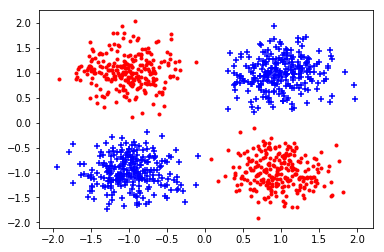

In [138]:
data1, y1 = gen_arti(data_type=1)
plot_data(data1, y1)

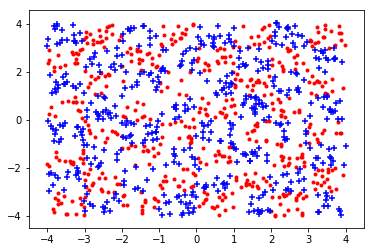

In [139]:
data2, y2 = gen_arti(data_type=2)
plot_data(data2, y2)

## Etude du jeu de données réelles

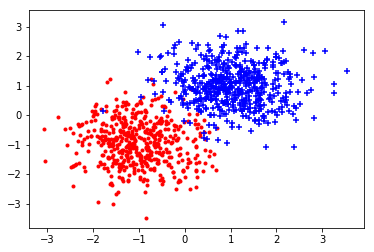

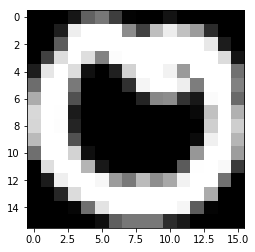

In [140]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")


### Donnees artificielles
plt.ion()
xgentrain,ygentrain = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
xgentest,ygentest = gen_arti(data_type=0,sigma=0.5,nbex=1000,epsilon=0.1)
plt.figure()
plot_data(xgentrain,ygentrain)

### Donnees reelles
plt.figure()
xuspstrain,yuspstrain = load_usps("USPS_train.txt")
xuspstest,yuspstest = load_usps("USPS_test.txt")
x06train,y06train = get_usps([0,6],xuspstrain,yuspstrain)
x06test,y06test = get_usps([0,6],xuspstest,yuspstest)
show_usps(x06train[0])


A mons avis, il est a priori plus simple de classifier 2 chiffres aux formes très différentes que de classifier un chiffre contre tous les autres.
En effet, il existe des paires de chiffres qui vont potentiellement être difficiles à différencier. Ce sont les paires qui ont des formes communes, comme peuvent l'être par exemple:
- 0 et 8
- 8 et 6
- 1 et 7
- 5 et 6

## Classifieur Bayésien

In [7]:
class Bayes:
    """Pour l'instant marche uniquement pour de la classification binaire"""
    def __init__(self, apriori=[1/2, 1/2]):
        self.p_y = apriori.copy()
        
        pass
    
    def predict(self,data):
        func = np.array([self.log_proba(data, ind) for ind, y in enumerate(self.nb_labels)]).T
        y_predict = np.argmax(func, axis=1)
        np.place(y_predict, y_predict==0, -1)
        return y_predict
                        
    def log_proba(self, x, label):
        mu, std = self.mu[label], self.std[label]
        logproba = -(x-mu)**2 + 2*(std**2)
        logproba = np.log(self.p_y[label]) + logproba
        logproba = np.sum(logproba, axis=1)
        return logproba
        
    def fit(self,data,labels):
        self.mu = []
        self.std = []
        self.nb_labels = np.unique(labels)
        for y in self.nb_labels:
            self.mu.append(np.mean(data[labels==y], axis=0))
            self.std.append(np.std(data[labels==y], axis=0))
        self.mu = np.array(self.mu)
        self.std = np.array(self.std)
        assert(len(self.mu)==len(self.nb_labels))
        pass
    
    def score(self,data,labels):
        return (self.predict(data)==labels).mean()
    


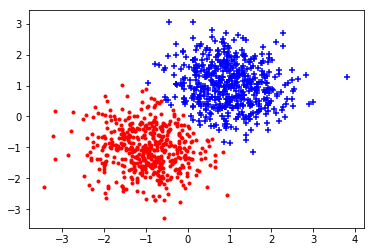

In [8]:
bay = Bayes()
bay.fit(xgentrain, ygentrain)
predict = bay.predict(xgentest)
plot_data(xgentest, predict)

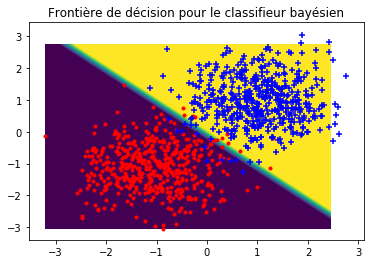

In [193]:
plt.figure()
plot_frontiere(xgentest, bay.predict)
plot_data(xgentest, ygentest)
plt.title("Frontière de décision pour le classifieur bayésien")

In [194]:
xuspstrain.shape

(7291, 256)

In [11]:
# Classification appliquée à des données réelles
bay = Bayes()
bay.fit(xuspstrain, yuspstrain)
y_pred = bay.predict()

TypeError: predict() missing 1 required positional argument: 'data'

In [ ]:
yuspstest[0]

** FINIR DERNIER QUESTION. POUR CELA PERMETTRE CLASSIFICATION MULTICLASSES **

# Descente de gradient

In [141]:
def optimize(func, dfunc, xinit, eps=0.1, max_iter=200):
    ind = 0
    xt = np.array(xinit) 
    ft = func(xinit) 
    dt = dfunc(xinit)
    X, F, D = [xt], [ft], [dt]
    for i in range(max_iter):
        xt = xt - eps*dt
        ft = func(xt)
        dt = dfunc(xt)
        X.append(xt)
        F.append(ft)
        D.append(dt)
    return np.array(X), np.array(F), np.array(D)

### a) Test sur la fonction $f:x \rightarrow x \cos (x)$

In [142]:
f = lambda x : x*np.cos(x)
df = lambda x : np.cos(x) - x*np.sin(x)
xs, fs, ds = optimize(f, df, xinit=5, eps=0.1, max_iter=100)

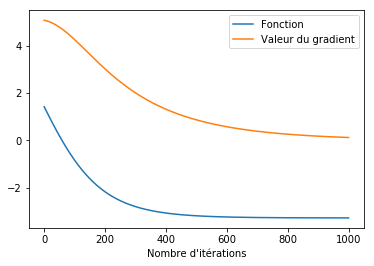

In [143]:
xs, fs, ds = optimize(f, df, xinit=5, eps=0.001, max_iter=1000)

n_iter = np.arange(len(xs))
plt.figure()
plt.plot(n_iter, fs, label="Fonction")
plt.plot(n_iter, ds, label="Valeur du gradient")
plt.xlabel("Nombre d'itérations")
plt.legend()

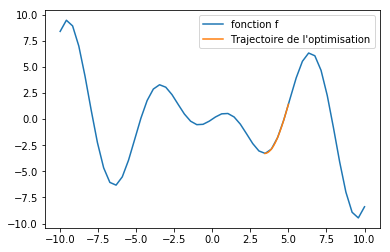

In [144]:
grid = np.linspace(-10, 10)
fgrid = [f(xi) for xi in grid]
plt.figure()
plt.plot(grid, fgrid, label='fonction f')
plt.plot(xs, fs, label="Trajectoire de l'optimisation")
plt.legend()

/home/pierre/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


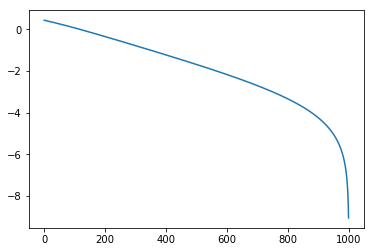

In [145]:
xs = xs.reshape(-1,1)
xhat = xs[-1] 
ts = np.arange(len(xs))
curb = np.log(np.linalg.norm(xs - xhat, axis=1))
plt.figure()
plt.plot(ts, curb)

### b) Test sur la fonction $f:x \rightarrow 100(x_2 - x_1^2)^2 + (1 - x_1)^2$ (2D)

In [146]:
func = lambda x: 100 * np.power((x[1] - np.power(x[0], 2)), 2) + np.power((1 - x[0]), 2)
dfunc = lambda x: np.array([200 * (x[1] - np.power(x[0], 2)) * (-2 * x[0]) - 2 * (1 - x[0]), 200 * (x[1] - np.power(x[0], 2))]) 
x2, f2, d2 = optimize(func, dfunc, xinit=np.array([0,0]), eps=1e-4, max_iter=50000)

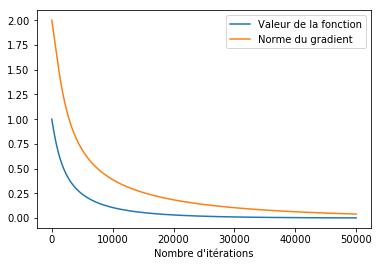

In [147]:
n_iter = np.arange(len(x2))
plt.figure()
plt.plot(n_iter, f2, label='Valeur de la fonction')
plt.plot(n_iter, np.linalg.norm(d2, axis=1), label='Norme du gradient')
plt.xlabel("Nombre d'itérations")
plt.legend()

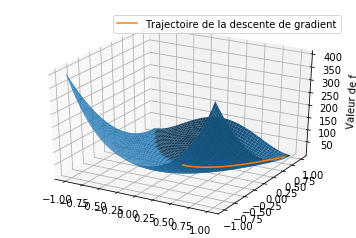

In [148]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

len_grid = 50j
f = lambda x, y: 100 * np.power((y - np.power(x, 2)), 2) + np.power((1 - x), 2)
xgrid, ygrid = np.mgrid[-1:1:len_grid, -1:1:len_grid]
z = f(xgrid, ygrid)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xgrid, ygrid, z)
ax.plot(x2[:,0], x2[:,1], f2, label='Trajectoire de la descente de gradient')
ax.set_zlabel('Valeur de f')
plt.legend()

/home/pierre/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


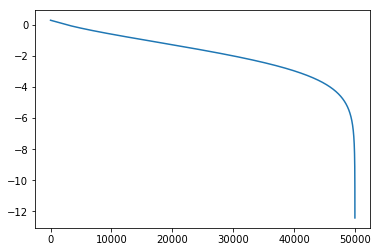

In [149]:
xhat = x2[-1] 
t2 = np.arange(len(x2))
curb = np.log(np.linalg.norm(x2 - xhat, axis=1))
plt.figure()
plt.plot(t2, curb)

### c) Remarques sur les résultats obtenus

Dans les 2 cas on remarque:
- La norme du gradient tend vers 0 quand le nombre d'itérations augmente. On atteint donc bien un minimum local
- En traçant la trajectoire de l'optimisation, on remarque qu'on atteint un minimum local si le problème n'est pas convexe. Le choix de xini est donc très important. On pourrait remédier à cette lacune en adoptant par exemple une méthode de recuit simulé.
- La courbe $(t, \log ||x^t - \hat{x}||)$ décroit avec le nombre d'itérations. **On aurait pu ajouter un critère d'arrêt basé sur cette valeur**. 

# Applications : Classification plug-in et Régression logistique


Calcul des gradients de coûts:
- Pour la classification plug-in.
Le coût s'écrit $L(w, X)= ||f_w(X) - Y||^2 = \frac{1}{N}\sum_i (f_w(X)_i-y_i)^2$
$$\frac{\partial L}{\partial w_j} = \frac{2}{N}\sum_i X_{ij}(f_w(X)_i - y_i)=2X_j^T(f_w(X)-y)$$
où X_j est le j ème vecteur colonne de X.
D'où enfin:
$$\nabla L = \frac{2}{N} X^T(f_w(X)-y)$$
- Pour la classification à l'aide de régression logistique:
$$L(w,X) = \sum_i \log(1 + e^{-y_if_w(x^i)})$$
Donc
$$\frac{\partial L}{\partial w_j} = - \sum_i \frac{y_i x_i^j \exp (-y_i.f_w(X)_i)}{1 + \exp(-y_i.f_w(X)_i)}$$


Remarque : penser à TOUJOURS TRANSFORMER EN MATRICES
data = data.reshape(len(label), -1)
label = labeL.reshape(-1, 1)

## a) MSE

In [150]:
def fw(x, w):
    return np.sum(np.multiply(x, w))

In [151]:
# MSE AND grad of MSE for plugin classification
def mse(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    vec = np.dot(data, w) - label
    return (vec**2).mean()

def grad_mse(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    vec = np.dot(data, w) - label
    return (2 / len(label))*np.dot(data.T, vec) 
    

## b) Logistic regression

In [152]:
def reglog(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    
    reg = np.dot(data, w)
    costs = np.log(1+np.exp(np.multiply(-label, reg)))
    return np.sum(costs) / len(label)

def grad_reglog(w, data, label):
    data = data.reshape((len(label),-1))
    label = label.reshape(-1)
    n, d = data.shape
    
    expo = np.exp(np.multiply(-label, np.dot(data, w)))
    common_v = - np.multiply(label, np.divide(expo, 1 + expo))
    
    res = np.array([np.multiply(data[:,j], common_v) for j in range(d)])
    return np.sum(res, axis=1) / len(label) 

## c) Interprétation et validation de la démarche sur données simulées

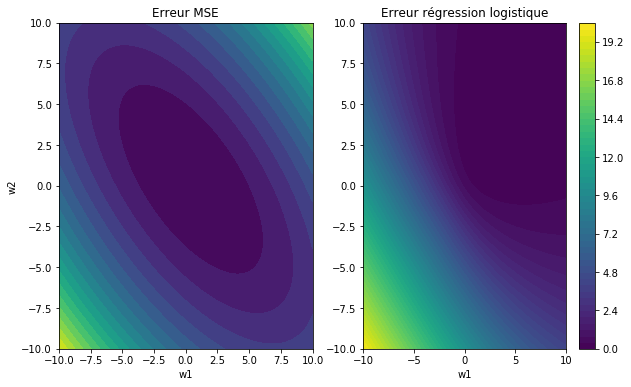

In [153]:
w1, w2 = np.mgrid[-10:10:100j, -10:10:100j]
err_mse = np.zeros((100,100))
err_reglog = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        wij = np.array([w1[i, j], w2[i, j]])
        err_mse[i, j] = mse(wij, data, label)
        err_reglog[i, j] = reglog(wij, data, label)

# Displaying 2 cost functions
plt.figure(1, figsize=(10, 6))
plt.subplot(1,2,1)
plt.contourf(w1, w2, err_mse, 20)
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Erreur MSE')

plt.subplot(1,2,2)
plt.contourf(w1, w2, err_reglog, 50)
plt.xlabel('w1')
plt.title('Erreur régression logistique')
plt.colorbar()


Pour l'erreur **MSE** le minimum est atteint pour w de norme faible.
Au contraire, quand on utilise la régression logistique, la fonction de coût a une norme minimale quand $w_{1,2} \rightarrow +\infty$.

Ce phénomène s'explique par le fait que pour cette dernière, quand $w=0$, la fonction de coût n'est pas minimale, et diminuerait pour une exponentielle à puissance négative.

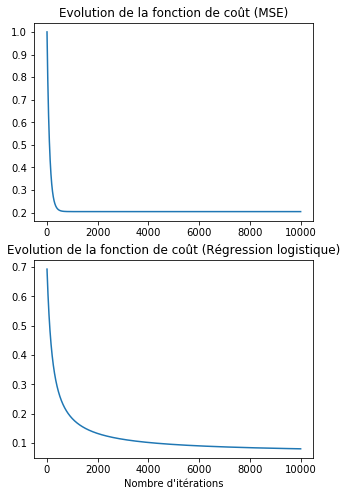

In [154]:
n,d = data.shape
dataintercept = np.hstack((np.ones((n, 1)), data))

mse0 = lambda w: mse(w, dataintercept, label)
grad_mse0 = lambda w: grad_mse(w, dataintercept, label)
x_mse, f_mse, d_mse = optimize(mse0, grad_mse0, [0, 0, 0], eps=1e-3, max_iter=10000)

rl = lambda w: reglog(w, dataintercept, label)
grad_rl = lambda w: grad_reglog(w, dataintercept, label)
x_rl, f_rl, d_rl = optimize(rl, grad_rl, [0, 0, 0], eps=5e-3, max_iter=10000)

plt.figure(figsize=(5, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(f_mse)),f_mse)
plt.title("Evolution de la fonction de coût (MSE)")
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(f_rl)),f_rl)
plt.title("Evolution de la fonction de coût (Régression logistique)")
plt.xlabel("Nombre d'itérations")



Maintenant qu'on a vu que nos algorithmes étaient a priori convergents, on implémente un classifieur plus général permettant la classification binaire à partir d'une descente de gradient sur la fonction de coût que l'on pourrait appliquer à d'autres fonctions de coût qui ont les mêmes propriétés que celles qu'on étudie.

In [165]:
class Classifier_GD:
    def __init__(self, function, dfunc, intercept=True):
        self.func = function
        self.dfunc = dfunc
        self.intercept = intercept
        pass
    
    def fit(self, data, label, eps=1e-4, max_iter=10000):
        n, d = data.shape
        if self.intercept:
            self.data =  np.hstack((np.ones((n, 1)), data))
        else:
            self.data = data.copy()
        self.label = label.copy()
        self.n, self.d = self.data.shape
        
        func0 = lambda w: self.func(w, self.data, self.label)
        dfunc0 = lambda w: self.dfunc(w, self.data, self.label)
        x, f, d = optimize(func0, dfunc0, [0 for i in range(self.d)], eps, max_iter)
        self.w = x[-1, :]
    
    def predict(self, data):
        n, d = data.shape
        prediction = np.ones((n, 1))
        if self.intercept:
            data0 = np.hstack((np.ones((n, 1)), data))
        else:
            data0 = data.copy()
        fw = np.dot(data0, self.w)
        prediction[fw < 0] = -1
        return prediction
    
    def accuracy(self, data, labels):
        ypred = self.predict(data)
        ypred = ypred.reshape(-1)
        return np.sum((labels == ypred)) / len(labels)
        
        

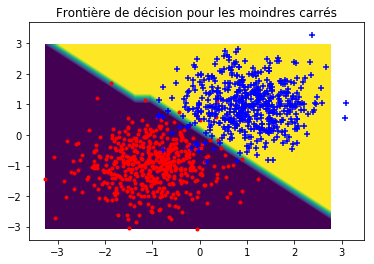

In [166]:
clf_mse = Classifier_GD(mse, grad_mse)
clf_mse.fit(data, label, eps=1e-3, max_iter=10000)

plt.figure()
plot_frontiere(xgentest, clf_mse.predict)
plot_data(xgentest, ygentest)
plt.title("Frontière de décision pour les moindres carrés")


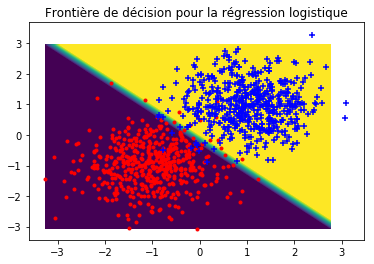

In [167]:
clf_rl = Classifier_GD(reglog, grad_reglog)
clf_rl.fit(data, label, eps=5e-3, max_iter=10000)

plt.figure()
plot_frontiere(xgentest, clf_rl.predict)
plot_data(xgentest, ygentest)
plt.title("Frontière de décision pour la régression logistique")


** Interprétation de valeurs extrémales de $f_w$ pour la régression logistique**

Les valeurs proches de 0 de $f_w$ correspondent aux entrées que l'on ne sait pas bien labeliser, celles extrémales celles sur lesquelles on a peu de doute. En effet, on peut **quantifier** notre certitude car $\frac{1}{1 + \exp(-f_w(x))}$ est la probabilité que $y=1$

** Interprétation de valeurs extrémales de $f_w$ pour les moindres carrés**

Pour interpréter $f_w$ comme pour la régression logistique, on affiche ci-dessous les valeurs de $f_w$ pour les points mal labellisés par notre classifieur.
Ce sont des points très proches de l'origine. Comme pour la régression logistique, on en déduit que si $f_w(x) \approx 0$ on risque de se tromper dans notre labellisation.
Pour autant, contrairement à la régression logistique, on ne peut pas donner un sens particulier au cas $f_w$ grand. **On ne peut pas non plus quantifier notre confiance dans notre labellisation**

In [169]:
y = clf_mse.predict(xgentest)
ygentest = ygentest.reshape((-1,1))
indices = np.where(y != ygentest)
indices = indices[0]
x_fault = np.hstack((np.ones((len(xgentest[indices, :]), 1)), xgentest[indices, :]))
print(np.dot(x_fault, clf_mse.w))

[ 0.57492001  0.18326411 -0.07122099 -0.00922885 -0.21795571 -0.16612642
 -0.01057256 -0.07944197 -0.12937875  0.06816284 -0.08540419 -0.25108477
 -0.22940244 -0.16137098  0.21902068  0.03393126 -0.51229002 -0.14391854
 -0.08288054  0.36506457 -0.07682423  0.11490527 -0.30080748  0.0093703
 -0.0451921   0.52914246  0.04368526]


Que dire maintenant de la précision des 2 méthodes?

In [168]:
print("Accuracy of classifier MSE:", clf_mse.accuracy(xgentest, ygentest))
print("Accuracy of classifier RegLog:", clf_rl.accuracy(xgentest, ygentest))

Accuracy of classifier MSE: 0.973
Accuracy of classifier RegLog: 0.972


Les précisions obtenues par les 2 méthodes (assez satisfaisantes) sont du même ordre. Pour cette base de données, on préfèrera donc la méthode **RegLog** par pour son interprétation de $f_w$ très précieuse.

## Expérimentation (classification binaire) sur données réelles

In [32]:
y06train.shape

(1858,)

In [59]:
clf = Classifier_GD(reglog, grad_reglog)
y06train[y06train==0] = -1
y06train[y06train==6] = 1
y06test[y06test==0] = -1
y06test[y06test==6] = 1
clf.fit(x06train, y06train, eps=5e-3, max_iter=10000)

In [60]:
y06pred = clf.predict(x06test).reshape(-1)

# Computing accuracy
accuracy = np.sum((y06test == y06pred)) / len(y06test)
print("Accuracy of :", accuracy)

Accuracy of : 0.986767485822


On obtient sur notre base de test une précision de près de **98%** pour distinguer les 6 des 0 pour la base de données USPS. C'est très bon.